<a href="https://colab.research.google.com/github/2303A51925/AIML-2024-25/blob/main/ieeepaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv("/content/car_data.csv")

In [3]:
def parse_price(x):
    if pd.isna(x): return np.nan
    s = re.sub(r"[^\d.]", "", str(x))
    return float(s) if s != "" else np.nan

In [4]:
def parse_mileage(x):
    if pd.isna(x): return np.nan
    s = str(x)
    if "Not available" in s or s.strip() == "":
        return np.nan
    s = re.sub(r"[^\d]", "", s)
    return float(s) if s != "" else np.nan

In [5]:
df["Price_num"] = df["Price"].apply(parse_price)
df["MSRP_num"] = df["MSRP"].apply(parse_price)
df["Mileage_num"] = df["Mileage"].apply(parse_mileage)
df["mileage_missing"] = df["Mileage"].apply(lambda x: 1 if ("Not available" in str(x) or pd.isna(x)) else 0)

In [6]:
df["Model_str"] = df["Model"].fillna("Unknown").astype(str)
df["Brand"] = df["Model_str"].apply(lambda s: s.split()[1] if len(s.split())>1 and s.split()[0].isdigit() else s.split()[0])
top_brands = df["Brand"].value_counts().nlargest(10).index
df["Brand_top"] = df["Brand"].apply(lambda x: x if x in top_brands else "Other")

In [7]:
df = df[df["Status"].isin(["New", "Used"])]
df["Status_bin"] = df["Status"].map({"New": 1, "Used": 0})

In [8]:
for col in ["Year", "Price_num", "MSRP_num", "Mileage_num"]:
    df[col] = df[col].fillna(df[col].median())

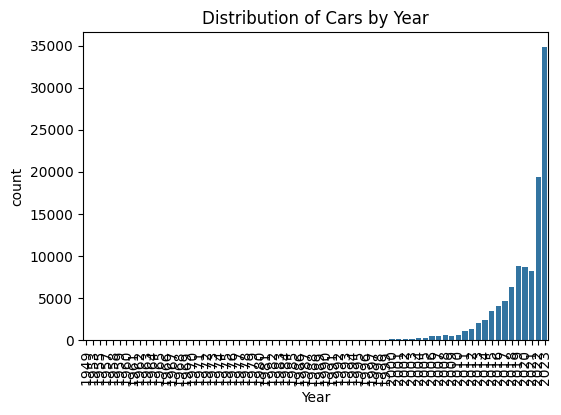

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x="Year", data=df, order=sorted(df["Year"].unique()))
plt.xticks(rotation=90)
plt.title("Distribution of Cars by Year")
plt.show()

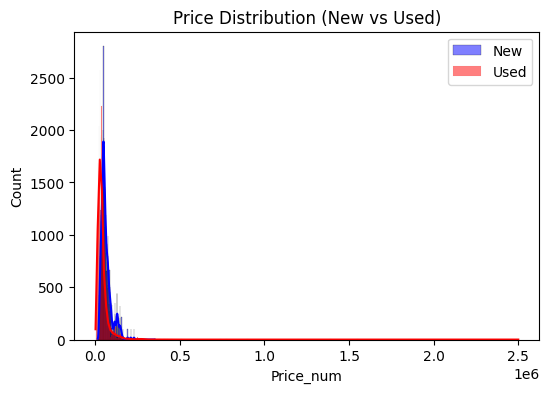

In [10]:
plt.figure(figsize=(6,4))
sns.histplot(df[df["Status"]=="New"]["Price_num"], color="blue", label="New", kde=True)
sns.histplot(df[df["Status"]=="Used"]["Price_num"], color="red", label="Used", kde=True)
plt.legend()
plt.title("Price Distribution (New vs Used)")
plt.show()

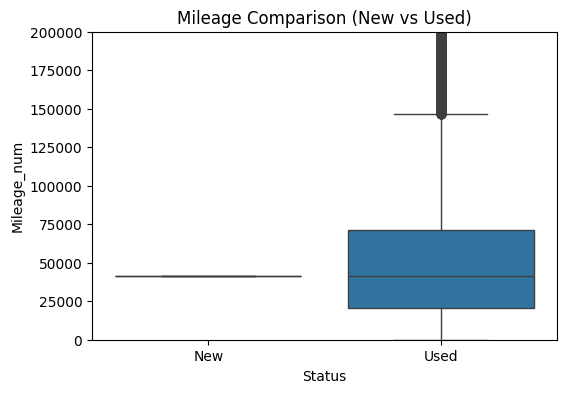

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Status", y="Mileage_num", data=df)
plt.ylim(0, 200000)
plt.title("Mileage Comparison (New vs Used)")
plt.show()

In [13]:
X = pd.concat([df[["Year","Price_num","MSRP_num","Mileage_num","mileage_missing"]],
               pd.get_dummies(df["Brand_top"], prefix="Brand")], axis=1)
y = df["Status_bin"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Used","New"]))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9999544232259241

Classification Report:
               precision    recall  f1-score   support

        Used       1.00      1.00      1.00     12370
         New       1.00      1.00      1.00      9571

    accuracy                           1.00     21941
   macro avg       1.00      1.00      1.00     21941
weighted avg       1.00      1.00      1.00     21941


Confusion Matrix:
 [[12369     1]
 [    0  9571]]


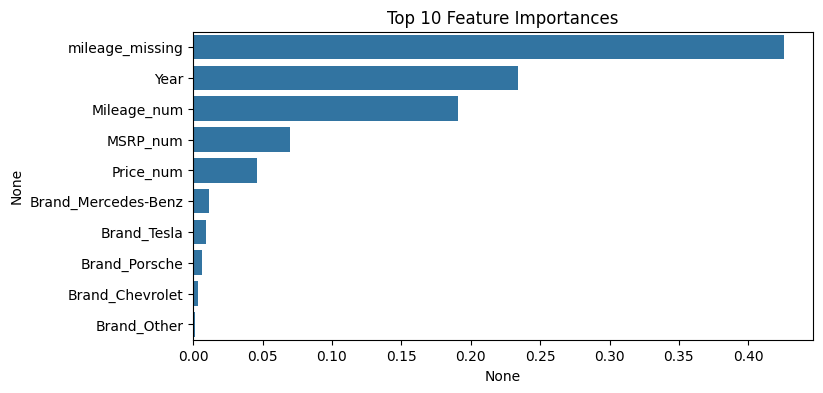

In [16]:
feat_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=feat_importances[:10], y=feat_importances.index[:10])
plt.title("Top 10 Feature Importances")
plt.show()